In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import cv2
import torch
import albumentations as A
import segmentation_models_pytorch as smp


from sklearn.model_selection import KFold
#from scripts.evaluation import get_test_f1
#from scripts.plotting import plot_metric_per_epoch, plot_n_predictions
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model
from torch.utils.data import DataLoader, SubsetRandomSampler
from matplotlib import pyplot as plt


In [3]:
ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'training')

In [27]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

SEED = 13
BATCH_SIZE = 4
K_FOLD = 5
N_CPU = os.cpu_count()
N_EPOCHS = 15

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE, 
    'num_workers': N_CPU, 
    'persistent_workers': True
}

In [28]:
# define transformations
train_transform = A.Compose([
    A.Resize(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),      
    A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    A.RandomBrightnessContrast(p=0.5), 
    A.RandomSnow(p=0.1)
])

test_transform = A.Compose([A.Resize(height=512, width=512, always_apply=True)])


# Image paths so that all the images are used for train dataset.
image_path_train, image_path_test, mask_path_train, mask_path_test = split_data(train_directory, test_size=0)

# Create train Dataset from all the images
train_dataset = RoadDataset(image_path_train, mask_path_train, train_transform)

In [29]:
# TODO: need to work with this (cross-validation)
k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

# Record K-fold results in a (K_FOLD, num_epoch) matrix
training_f1_matrix = []
validation_f1_matrix = []


# Get training and validation indices 
for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):
    
    # Initialize model
    model_ = smp.create_model("FPN", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
    criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
    optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)

    # Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
    train_loader = DataLoader(train_dataset, sampler=SubsetRandomSampler(train_idx), **LOADER_PARAMS)
    valid_loader = DataLoader(train_dataset, sampler=SubsetRandomSampler(val_idx), **LOADER_PARAMS)

    # Train model
    train_losses, valid_losses, train_f1s, valid_f1s = train_model(
        model_, (train_loader, valid_loader), criterion_, optimizer_, N_EPOCHS
    )
    
    # Save epoch results
    training_f1_matrix.append(train_f1s)
    validation_f1_matrix.append(valid_f1s)

Epoch:   1. Train.      Loss: 0.583 | f1: 0.414: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]
Epoch:   1. Validation. Loss: 0.544 | f1: 0.467: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]
Epoch:   2. Train.      Loss: 0.399 | f1: 0.589: 100%|██████████| 20/20 [00:03<00:00,  6.49it/s]
Epoch:   2. Validation. Loss: 0.427 | f1: 0.546: 100%|██████████| 5/5 [00:00<00:00, 16.34it/s]
Epoch:   3. Train.      Loss: 0.328 | f1: 0.656: 100%|██████████| 20/20 [00:03<00:00,  6.44it/s]
Epoch:   3. Validation. Loss: 0.394 | f1: 0.586: 100%|██████████| 5/5 [00:00<00:00, 16.45it/s]
Epoch:   4. Train.      Loss: 0.307 | f1: 0.676: 100%|██████████| 20/20 [00:03<00:00,  6.52it/s]
Epoch:   4. Validation. Loss: 0.337 | f1: 0.641: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s]
Epoch:   5. Train.      Loss: 0.263 | f1: 0.716: 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]
Epoch:   5. Validation. Loss: 0.275 | f1: 0.688: 100%|██████████| 5/5 [00:00<00:00, 15.09it/s]
Epoch:   6. Train.      Loss: 0.230 | f1

In [24]:
from typing import Union

import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from distutils.spawn import find_executable

from scripts.array_manipulations import simplify_array
from scripts.evaluation import get_patched_f1, get_correct_mask, get_prediction
from scripts.preprocessing import get_patched_classification


def plot_kfold_results(matrix, title):

    plt.set_cmap('Set2')

    # use latex whenever possible
    plt.rc('text', usetex=bool(find_executable('latex')))
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Dark2.colors)

    # force epochs to integers
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

    # Put epoch count on x-axis
    x = np.arange(len(matrix[0]))

    # Map F1 function for each K-Fold
    for i in range(len(matrix)):
        plt.plot(x, matrix[i], label=f"Fold nr={i}")

    plt.xlabel('epoch', fontsize=16)
    plt.ylabel("y", fontsize=16)
    if title:
        plt.title(title, fontsize=20)

    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    plt.grid(color="#d3d3d3", linestyle="--", linewidth=0.5)
    plt.legend(fontsize=16)
    plt.tight_layout()


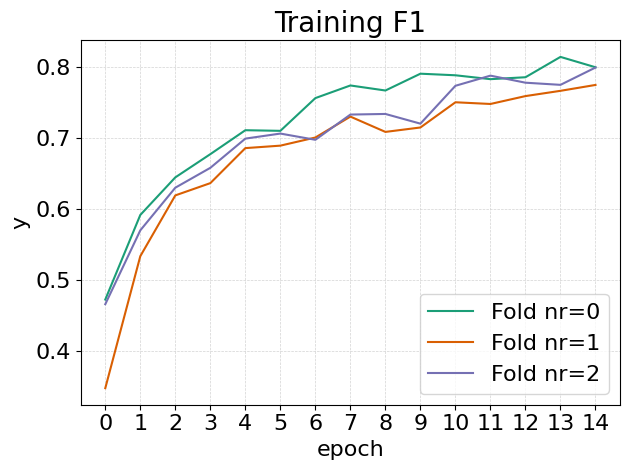

In [25]:
plot_kfold_results(training_f1_matrix, "Training F1")

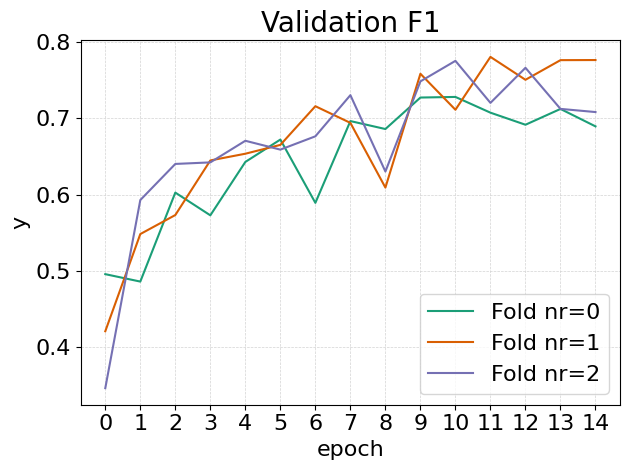

In [26]:
plot_kfold_results(validation_f1_matrix, "Validation F1")